# Práctica 5: Modelo de clasificación de ligandos

> **Nota:** Este libro esta disponible de dos maneras: 
> 1. Descargando el repositorio y siguiendo las instrucciones que estan en el archivo [README.md](https://github.com/ramirezlab/CHEMO/blob/main/README.md)
> 2. Haciendo clic aquí en [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ramirezlab/CHEMO/blob/main/3_PART_THREE/3.2_Practica-1.es.ipynb?hl=es)

## Introducción
El aprendizaje automático se ha consolidado como un componente esencial en la ciencia de datos, habilitando a las computadoras para aprender de los datos y tomar decisiones o hacer predicciones sin ser explícitamente programadas para ello. Dentro de este marco, un algoritmo de particular importancia es el modelo de clasificación de *RandomForest*.

<img src="./img/random_forest_es.png" width="600" align='right'>

El modelo de RandomForest es un algoritmo de aprendizaje supervisado que se fundamenta en el método de ensamble. Este método conjuga varios algoritmos más débiles para conformar un modelo más potente y robusto. En el caso de RandomForest, se crea un "bosque" de *árboles de decisión*, cada uno entrenado en un subconjunto aleatorio de los datos <sup> **1** </sup>. El resultado final es la combinación de las predicciones de todos estos árboles individuales.

RandomForest se caracteriza por ser versátil y eficiente, capaz de manejar un gran número de características y de abordar tanto problemas de clasificación como de regresión. Una de las ventajas de este algoritmo es que proporciona una medida de la importancia de las variables, ofreciendo un conocimiento valioso acerca del modelo y los datos.

### Estrategia de validación: validación cruzada de K-fold

La validación de modelos es un paso crucial en el desarrollo de cualquier algoritmo de aprendizaje automático. Su finalidad es evaluar qué tan bien el modelo aprendido puede generalizar a datos no vistos, es decir, que no se utilizaron durante la fase de entrenamiento. En nuestra práctica, emplearemos la estrategia de validación cruzada de K-Fold.

<img src="./img/K-fold_Cross_Validation_es.png" width="500" align='left'>

La validación cruzada de K-Fold es una técnica potente y ampliamente utilizada que mejora la estimación del rendimiento del modelo. En vez de dividir el conjunto de datos una sola vez en un conjunto de entrenamiento y un conjunto de prueba, la validación cruzada de K-Fold divide el conjunto en 'K' subconjuntos distintos. Luego, el algoritmo se entrena 'K' veces, utilizando en cada ocasión un subconjunto diferente como conjunto de prueba y el resto de los subconjuntos como conjunto de entrenamiento. Finalmente, el rendimiento del modelo se promedia en las 'K' iteraciones para obtener una estimación más robusta <sup> **2** </sup>.

El objetivo es probar la capacidad del modelo para predecir datos no vistos anteriormente, detectar problemas como el sobreajuste y evaluar la capacidad de generalización del modelo.


### Medidas de desempeño

La elección de las medidas de desempeño depende de la naturaleza del problema que se está abordando. Sin embargo, hay algunas medidas comunes que suelen ser útiles para evaluar el rendimiento de los modelos de clasificación. Para entender y calcular estas medidas de desempeño, es útil conocer sus fórmulas. Antes de proporcionar las fórmulas, es importante destacar que se basan en los conceptos de Verdaderos Positivos (**TP**), Falsos Positivos (**FP**), Verdaderos Negativos (**TN**), y Falsos Negativos (**FN**), que son las cuatro categorías posibles en las que se pueden clasificar las predicciones de nuestro modelo. La matriz de confusión resulta útil para diferenciar cada concepto <sup> **3** </sup>:

<img src="./img/confusion_matrix_es.png" width="400">

* **Exactitud (Accuracy)**: Es la proporción de predicciones correctas entre el total de predicciones realizadas. Aunque es una medida intuitiva y fácil de entender, la exactitud puede ser engañosa si las clases están desequilibradas. La exactitud se calcula como la suma de las predicciones correctas (tanto positivas como negativas) dividida por el total de predicciones.
  $$Accuracy = \dfrac{TP + TN}{TP + TN + FP + FN}$$

* **Precisión (Precision)**: Es la proporción de predicciones positivas que fueron correctas. Es una medida útil cuando los falsos positivos son particularmente preocupantes. La precisión se calcula como el número de verdaderos positivos dividido por la suma de verdaderos positivos y falsos positivos.
  $$Precision = \dfrac{TP}{TP+FP}$$

* **Recall (Sensibilidad)**: Es la proporción de casos positivos reales que el modelo identificó correctamente. Es importante cuando los falsos negativos son una preocupación. El recall se calcula como el número de verdaderos positivos dividido por la suma de verdaderos positivos y falsos negativos.
  $$Recall = \dfrac{TP}{TP + FN}$$

* **Puntuación F1 (F1 Score)**: Es la media armónica de la precisión y el recall. Esta medida busca un equilibrio entre la precisión y el recall. La puntuación F1 se calcula como el promedio armónico de la precisión y el recall.
  $$F1_{score} = 2 \times \dfrac{Precision \times Recall}{Precision + Recall}$$

* **Curva ROC (Receiver Operating Characteristic)** <sup> **3** </sup>: Esta curva es una representación gráfica que ilustra la capacidad discriminativa de un clasificador binario a medida que varía su umbral de discriminación. Se crea trazando la tasa de verdaderos positivos (Recall) contra la tasa de falsos positivos (1-Especificidad), a varios niveles de umbral. Un modelo con un poder predictivo perfecto se ubicaría en la esquina superior izquierda del gráfico, mientras que un modelo aleatorio seguiría la línea diagonal.

* **AUC (Área bajo la curva, en inglés Area Under the Curve)**: Esta métrica se calcula como el área bajo la curva ROC. Un AUC de 1.0 denota un modelo perfecto, mientras que un AUC de 0.5 denota un modelo que no tiene capacidad de discriminación, equivalente a una selección aleatoria. Cuanto mayor sea el AUC, mejor será el modelo en distinguir entre las clases positiva y negativa.

En nuestro análisis de la implementación del modelo RandomForest, utilizaremos estas medidas para evaluar su desempeño y capacidad de generalización.

# Preparación de los datos
Iniciamos importando los datos de la práctica anterior, como estos están guardados en la carpeta de la segunda parte, podemos crear un `directorio raíz` (`ROOT_DIR`) para navegar hasta el archivo y cargarlo en un dataframe

## Carga de los datos

In [23]:
import pandas as pd
import os
from pathlib import Path
import requests

# Definir el ID de UniProt y la URL del archivo CSV
uniprot_id = 'P49841'
csv_url = 'https://raw.githubusercontent.com/ramirezlab/CHEMO/main/2_PART_TWO/data/compounds_P49841_lipinski.csv'

# Leer el archivo CSV desde la URL y cargarlo en un DataFrame
df_output = pd.read_csv(csv_url)

# Mostrar las primeras filas del DataFrame
df_output.head()

,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...,484.211055,7,1,3.2107,yes
4,CHEMBL3957649,9.70,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...,393.171336,7,3,1.9218,yes


En esta práctica necesitamos solamente los ligandos que cumplen la *regla de los cinco*, por tanto, debemos filtrar por la columna: `rule_of_five_conform:yes`. Además, solamente necesitamos las primeras tres columnas

In [24]:
print(f'# lignados totales: {len(df_output)}')
df_output = df_output[df_output['rule_of_five_conform']=='yes']
df_output = df_output[['molecule_chembl_id', 'pchembl_value', 'smiles']]
print(f'# ligandos filtrados (rule_of_five_conform:yes): {len(df_output)}')

df_output.head()

# lignados totales: 2697
# ligandos filtrados (rule_of_five_conform:yes): 2510


,molecule_chembl_id,pchembl_value,smiles
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL3957649,9.70,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1



## Procesamiento de los datos
### Huellas Dactilares Moleculares (Fingerprints)

Para entrenar nuestro algoritmo, es necesario convertir los ligandos en una lista de características. Actualmente, disponemos de la estructura molecular (SMILES) de cada ligando, y con esta información podemos generar una representación alternativa conocida como *fingerprint*. Esta representación se utilizará posteriormente para entrenar el modelo.

Para identificar y generar las huellas dactilares de cada ligando, utilizaremos la librería `rdkit`. Esta operación resultará en la creación de una nueva columna en nuestro conjunto de datos que contendrá el fingerprint de cada ligando. Existen varios tipos de fingerprints, pero en esta ocasión trabajaremos con la [Extended Connectivity Fingerprint ECFP](https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md) también conocida como morgan2_c/ecfp4 <sup> **4** </sup>.

In [25]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
df_fp = df_output.copy()
df_fp['morgan2_c'] = df_output.smiles.map(lambda smile: rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2).ToList())
df_fp = df_fp[['molecule_chembl_id', 'morgan2_c', 'pchembl_value']]
df_fp.head()

,molecule_chembl_id,morgan2_c,pchembl_value
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85
4,CHEMBL3957649,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70


Exploremos el primer fingerprint: una lista binaria (unos y ceros) con una longitud de 2048 elementos. Estos elementos de la fingerprint serán las características que se usarán para entrenar el modelo.

In [26]:
print(df_fp.morgan2_c[0])
print(len(df_fp.morgan2_c[0]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Clasificación de los ligandos

Cada ligando debe ser clasificado como **activo** o **inactivo**, para esto usaremos la columna `pchembl_value` definiendo umbrales de actividiad
La proteína *Glycogen synthase kinase-3 beta* se clasifica en el grupo de las *Kinasas*, por tanto, usaremos los siguientes umbrales:

**Inactivo**: *pchembl_value* < 6.52 uM

**Activo**: *pchembl_value* >= 7.52 uM

In [27]:
# Añadir columna actividad, default = internet
df_fp['activity_type'] = 'Intermediate'
# Marcar cada molecula como activa con un pchembl_value >= 7.52
df_fp.loc[df_fp[df_fp.pchembl_value >= 7.5].index, 'activity_type'] = 'Active'
# Marcar cada molecula como inactiva con un pchembl_value < 6.52
df_fp.loc[df_fp[df_fp.pchembl_value < 6.52].index, 'activity_type'] = 'Inactive'
df_fp.head()

,molecule_chembl_id,morgan2_c,pchembl_value,activity_type
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89,Active
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85,Active
4,CHEMBL3957649,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70,Active


Veamos gráficamente cómo quedo la clasificación

activity_type
Inactive        1195
Intermediate     685
Active           630
Name: count, dtype: int64


<Axes: xlabel='activity_type'>

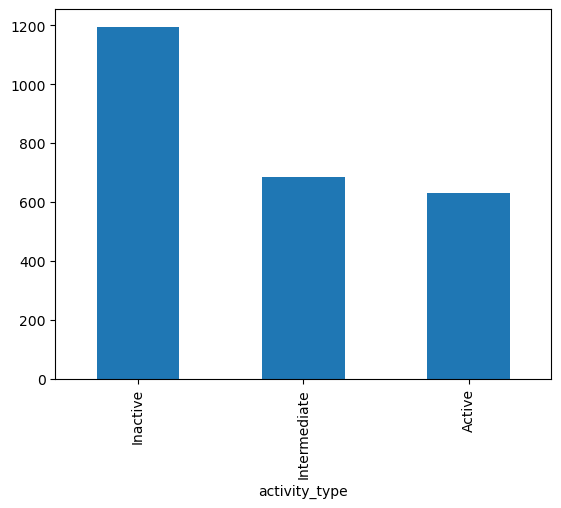

In [53]:
print(df_fp.activity_type.value_counts())
df_fp.activity_type.value_counts().plot.bar(x='activity_type')

Ahora filtramos los datos quitando aquellos que se calsificaron como *Intermedios*

# ligandos (active/inactive): 1825
activity_type
Inactive    1195
Active       630
Name: count, dtype: int64


,molecule_chembl_id,morgan2_c,pchembl_value,activity_type
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89,Active
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85,Active
4,CHEMBL3957649,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70,Active


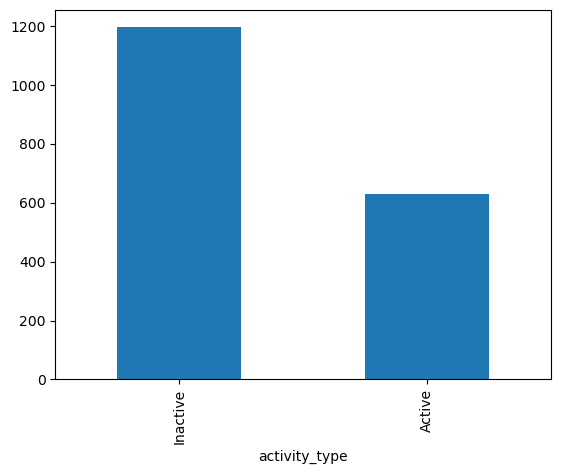

In [54]:
bd = df_fp[df_fp['activity_type'] != 'Intermediate'].copy()
bd.activity_type.value_counts().plot.bar(x='activity_type')
print(f'# ligandos (active/inactive): {len(bd)}')
print(bd.activity_type.value_counts())
bd.head()

Como es una clasificación binaria, debemos asignar una etiqueta: (Inactive:0 / Active:1)

In [30]:
bd['activity'] = 0
bd.loc[bd[bd.activity_type == 'Active'].index, 'activity'] = 1.0
bd.drop(['activity_type', 'pchembl_value'], axis=1, inplace=True)
bd.head()

,molecule_chembl_id,morgan2_c,activity
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1
4,CHEMBL3957649,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


Ya tenemos las características (morgan2_c fingerprint) y etiquetas (activity) para poder entrenar el modelo


# Entrenamiento del modelo con el algoritmo *Random Forest*

Vamos a entrenar un modelo de Random Forest que clasifique ligandos conociendo el fingerprint. El objetivo es probar la capacidad del modelo para predecir datos que nunca antes había visto para detectar problemas conocidos como sobreajuste y evaluar la capacidad de generalización del modelo.

### Random Forest
Usualmente, el primer paso es **dividir** el conjunto de datos, una parte para el entrenamiento (70%) y la otra parte para la prueba(30%).


In [31]:
from sklearn.model_selection import train_test_split
fp_df_train, fp_df_test = train_test_split(bd, test_size=0.3, random_state=142857,
                                            shuffle=True, stratify=bd['activity'])
fp_df_train.reset_index(drop=True, inplace=True)
fp_df_test.reset_index(drop=True, inplace=True)
print(f'# datos entrenamiento: {len(fp_df_train)},'
      f'\n# datos prueba: {len(fp_df_test)}')

# datos entrenamiento: 1277,
# datos prueba: 548


Ahora, para cada conjunto vamos a separar las características (el fingerprint) y la etiqueta

In [32]:
X_train, y_train = fp_df_train.morgan2_c, fp_df_train.activity
X_test, y_test = fp_df_test.morgan2_c, fp_df_test.activity
# El vector de características se deben convertir a una lista de elementos
X_train, X_test = X_train.tolist(), X_test.tolist()

Escogemos el estimador de [Random Fores classificator](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para entrenar el modelo, se debe instanciar y construir el modelo

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## Validación
### Accuracy score

Existen varias métricas para medir la capacidad del modelo para hacer predicciones, vamos a ver un ejemplo usando la métrica [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy_score#sklearn.metrics.accuracy_score).

Lo primero es clasificar (*predecir*) los datos del conjunto y luego compararlos con las etiquetas verdaderas, esto lo haremos tanto con el **conjunto de entrenamiento** como con el **conjunto de prueba**:

In [34]:
from sklearn.metrics import accuracy_score
# Predicción conjunto de entrenamiento
y_train_pred = model.predict(X_train)
# Predicción conjunto de validación
y_test_pre = model.predict(X_test)

# Puntuación
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pre)
print(f'Accuracy conjunto de entrenamiento: {acc_train:.4f} ({acc_train:.2%})\n'
      f'Accuracy conjunto de prueba: {acc_test:.4f} ({acc_test:.2%})')


Accuracy conjunto de entrenamiento: 1.0000 (100.00%)
Accuracy conjunto de prueba: 0.9088 (90.88%)


El *accuracy* del conjunto de entrenamiento es del 100%, lo cual indica un caso de Sobreajuste (*Overfitting*), posiblemente se deba hacer un ajuste de los parámetros del modelo de clasificación o incluso utilizar otro modelo.

### Matriz de confusión
Con esta matriz se puede comparar las etiquetas verdaderas versus las predicciones del modelo, [aquí](https://en.wikipedia.org/wiki/Confusion_matrix) se puede ver más información sobre la matriz de confusión. En este caso vamos a comparar los datos del conjunto de validación:

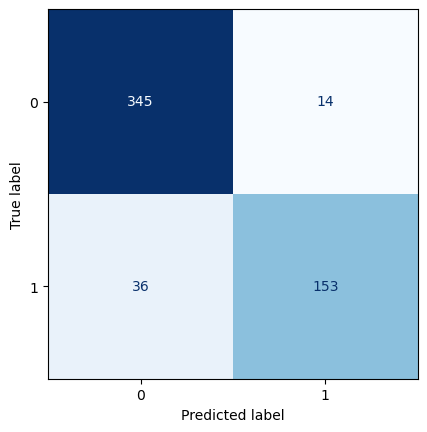

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,  cmap=plt.cm.Blues)

Se puede trabajar con los datos normalizados para verlos en forma de porcentaje

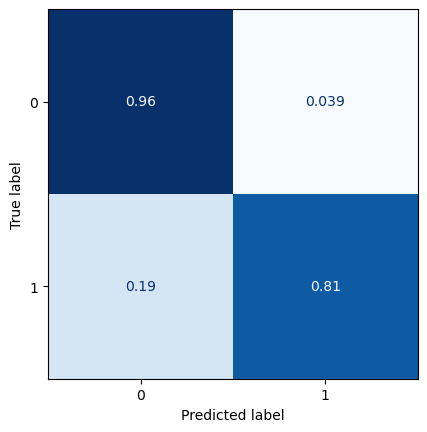

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,
                                        cmap=plt.cm.Blues, normalize='true')

### Curva ROC
La curva ROC (ROC curve, Receiver Operating Characteristic) es una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario según se varía el umbral de discriminación, usualmente se suele utilizar para representar qué tan bueno es el modelo, veamos como se puede construir una:

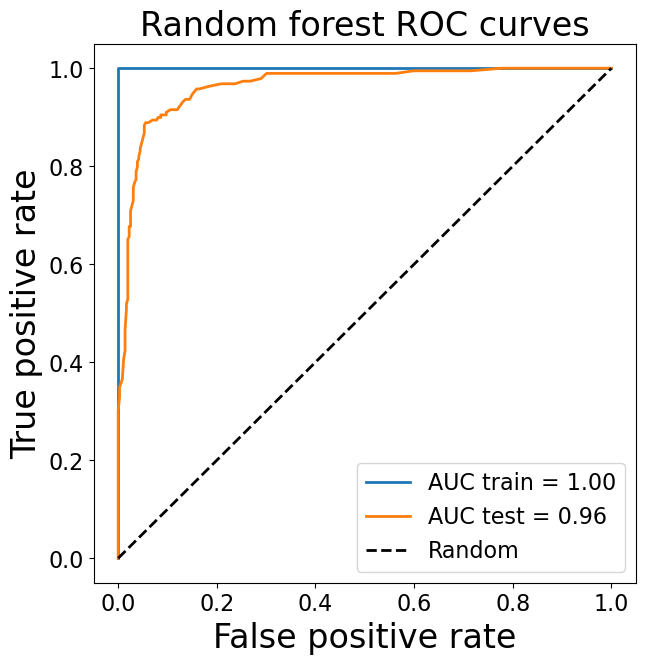

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib as mpl
import matplotlib.pyplot as plt

# Probabilidad de las predcciones
pred_prob_train = model.predict_proba(X_train)[:, 1]
pred_prob_test = model.predict_proba(X_test)[:, 1]

# tasas de falsos positivos / tasas de verdaderos positivos - entrenamiento
fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
# tasas de falsos positivos / tasas de verdaderos positivos - prueba
fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7, 7))
plt.plot(fpr_train, tpr_train, label=f'AUC train = {roc_auc_train:.2f}', lw=2)
plt.plot(fpr_test, tpr_test, label=f'AUC test = {roc_auc_test:.2f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Curva aleatoria

plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title('Random forest ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

### K-fold (validación cruzada)

Vamos dividir los datos en 5 conjuntos, cada uno de ellos entrenará el algoritmo y medirá su capacidad de predicción, luego se contrastarán los datos de los cinco modelos para validar si el modelo entrenado funciona o no.

In [38]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

n_folds = 5
# Vector de resultados vacío
results = []
# Mezcla los índices para la validación cruzada de k-fold
kf = KFold(n_splits=n_folds, shuffle=True)
# Etiquetas inicializadas con -1 para cada punto de datos
labels = -1 * np.ones(len(bd))
# Modelo de instancia
model = RandomForestClassifier()

for train_index, test_index in kf.split(bd):
    # Entrenamiento
    # Convierte el vector de bits y la etiqueta en una lista
    train_x = bd.iloc[train_index].morgan2_c.tolist()
    train_y = bd.iloc[train_index].activity.tolist()

    # Ajustar el modelo
    model.fit(train_x, train_y)

    # Pruebas
    # Convierte el vector de bits y la etiqueta en una lista
    test_x = bd.iloc[test_index].morgan2_c.tolist()
    test_y = bd.iloc[test_index].activity.tolist()
    # Predecir en el conjunto de prueba
    prediction_prob = model.predict_proba(test_x)[:, 1]
    # Guardar la etiqueta predicha de cada pliegue
    labels[test_index] = model.predict(test_x)

    # Actuación
    # Obtenga fpr, tpr y roc_auc para cada pliegue
    fpr_l, tpr_l, _ = roc_curve(test_y, prediction_prob)
    roc_auc_l = auc(fpr_l, tpr_l)
    # Agregar a los resultados
    results.append((fpr_l, tpr_l, roc_auc_l))
# Obtenga precisión general, sensibilidad, especificidad
y = bd.activity.tolist()
acc = accuracy_score(y, labels)
sens = recall_score(y, labels)
spec = (acc * len(y) - sens * sum(y)) / (len(y) - sum(y))

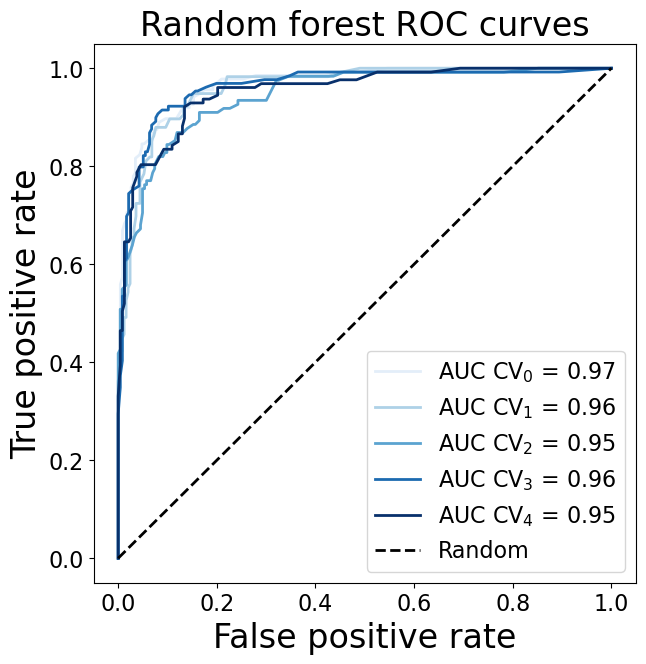

In [39]:
plt.figure(figsize=(7, 7))
cmap = mpl.colormaps['Blues']
colors = [cmap(i) for i in np.linspace(0.1, 1.0, n_folds)]

for i, (fpr_l, tpr_l, roc_auc_l) in enumerate(results):
    plt.plot(fpr_l, tpr_l, label='AUC CV$_{0}$ = {1:0.2f}'.format(str(i),roc_auc_l), lw=2, color=colors[i])
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title(f'Random forest ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

plt.show()

In [40]:
# Calcule el AUC media e imprima
m_auc = np.mean([elem[2] for elem in results])
print(f'Mean AUC: {m_auc:.3f}')

# Mostrar precisión general, sensibilidad, especificidad
print(f'Sensitivity: {sens:.3f}\nAccuracy: {acc:.3f}\nSpecificity: {spec:.3f}')

Mean AUC: 0.958
Sensitivity: 0.797
Accuracy: 0.893
Specificity: 0.943


## Conclusiones
El algoritmo de clasificación Random Forest es excepcionalmente potente para realizar clasificaciones binarias. En el caso de nuestro estudio, esto implicó clasificar moléculas como activas o inactivas. No obstante, nuestra implementación inicial del modelo reveló un sobreajuste significativo de los datos. Este fenómeno sugiere que el algoritmo intenta captar todas las características de las moléculas en lugar de lograr una generalización efectiva. Un exceso de ajuste puede llevar a una baja capacidad de predicción para moléculas que no forman parte del conjunto de entrenamiento, un escenario que preferiríamos evitar.

# Machine Learning XGBoost

Una alternativa al problema de sobreajuste es explorar la utilización de un modelo de clasificación distinto para entrenar nuestro algoritmo. En esta ocasión, decidimos implementar XGBoost, una eficiente y sofisticada biblioteca de software de aprendizaje automático basada en el algoritmo de boosting de árboles de decisión <sup> **5** </sup> .

XGBoost, que significa eXtreme Gradient Boosting, es conocido por su velocidad y rendimiento. Es un algoritmo que ha demostrado ser valioso en una variedad de competencias de ciencia de datos y ha sido ampliamente adoptado en la industria. Como algoritmo de boosting, XGBoost se basa en la idea de crear un modelo predictivo fuerte a través de la combinación de una serie de modelos más débiles, mejorando de manera iterativa las predicciones del conjunto.


## Entrenamiento del modelo

En esta práctica vamos a entrenar un modelo con unos parámetros establecidos de antemano, los cuales mejoran el modelo por defecto.

In [41]:
import xgboost as xgb
xgbc_model = xgb.XGBClassifier()
# training parameters
params = {'objective': 'binary:logistic', 'early_stopping_rounds': 20,
           'enable_categorical': False, 'eval_metric': ['error', 'auc'],
           'gamma': 0.2, 'grow_policy': 'depthwise',
           'learning_rate': 0.32, 'max_depth': 7,
           'min_child_weight': 1, 'n_estimators': 100,
           'scale_pos_weight': 3.271, 'subsample': 0.8,
           'alpha': 0.2, 'lambda': 1.4}
xgbc_model.set_params(**params)

XGBClassifier(alpha=0.2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['error', 'auc'],
              feature_types=None, gamma=0.2, gpu_id=None,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=1.4, learning_rate=0.32,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

Para entrenar el modelo XGBoost es necesario generar un conjunto de validación para usar la funcionalidad de "early stopping" de XGBoost. "Early stopping" es una forma de prevenir el sobreajuste del modelo deteniendo el entrenamiento cuando el error de validación deja de mejorar.

Por tanto, nuestro conjunto inicial `X_train, y_train` se divide en dos: `X_temp, y_temp` y `X_valid, y_valid` con una razón de 80:20.

Luego podemos entrenar el modelo:

In [42]:
X_temp, X_valid, y_temp, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
xgbc_model.fit(X_temp, y_temp, eval_set=[(X_valid, y_valid)])

[0]	validation_0-error:0.25391	validation_0-auc:0.81419
[1]	validation_0-error:0.24219	validation_0-auc:0.85467
[2]	validation_0-error:0.26172	validation_0-auc:0.86577
[3]	validation_0-error:0.21484	validation_0-auc:0.88078
[4]	validation_0-error:0.20312	validation_0-auc:0.89604
[5]	validation_0-error:0.20703	validation_0-auc:0.90118
[6]	validation_0-error:0.19141	validation_0-auc:0.90669
[7]	validation_0-error:0.17578	validation_0-auc:0.90672
[8]	validation_0-error:0.17969	validation_0-auc:0.90967
[9]	validation_0-error:0.17578	validation_0-auc:0.91132
[10]	validation_0-error:0.17188	validation_0-auc:0.91301
[11]	validation_0-error:0.17578	validation_0-auc:0.91071
[12]	validation_0-error:0.15625	validation_0-auc:0.91315
[13]	validation_0-error:0.15625	validation_0-auc:0.91376
[14]	validation_0-error:0.15234	validation_0-auc:0.91464
[15]	validation_0-error:0.15625	validation_0-auc:0.91498
[16]	validation_0-error:0.16016	validation_0-auc:0.91457
[17]	validation_0-error:0.16406	validatio

XGBClassifier(alpha=0.2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['error', 'auc'],
              feature_types=None, gamma=0.2, gpu_id=None,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=1.4, learning_rate=0.32,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

## Salvar y Cargar el modelo

Una vez entrenado el modelo se puede guardar, para esto utilizamos el comando `save_model`.

In [43]:
!mkdir -p ./data
xgbc_model.save_model('data/P49841_model.json')

The syntax of the command is incorrect.


Para cargarlo y utilizarlo, se utiliza el comando `load_model()`, por ejemplo:

In [44]:
new_model = xgb.XGBClassifier()
new_model.load_model('data/P49841_model.json')

## Validación del modelo
Con el modelo ya entrenado como `xgbc_model`, ahora podemos evaluar las métricas de desempeño, por ejemplo el accuracy:

In [45]:
# Predicción conjunto de entrenamiento
y_train_pred = xgbc_model.predict(X_train)
# Predicción conjunto de prueba
y_test_pre = xgbc_model.predict(X_test)

# Puntuación
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pre)
print(f'Accuracy conjunto de entrenamiento: {acc_train:.4f} ({acc_train:.2%})\n'
      f'Accuracy conjunto de prueba: {acc_test:.4f} ({acc_test:.2%})')


Accuracy conjunto de entrenamiento: 0.9655 (96.55%)
Accuracy conjunto de prueba: 0.8960 (89.60%)


Este resultado indica que el sobreajuste se ha disminuido.

Veamos la matriz de confusión:

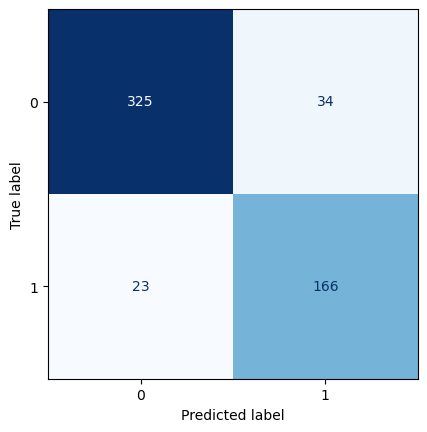

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,  cmap=plt.cm.Blues)

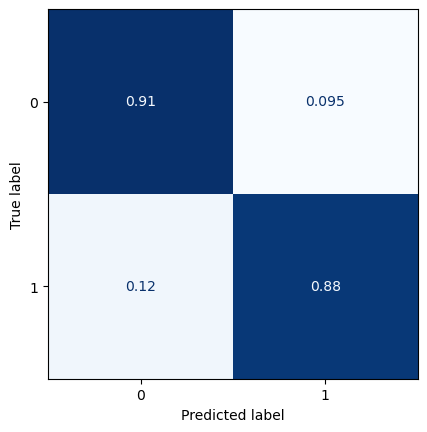

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,
                                        cmap=plt.cm.Blues, normalize='true')

También se puede repetir el proceso para graficar la curva ROC junto con el AUC

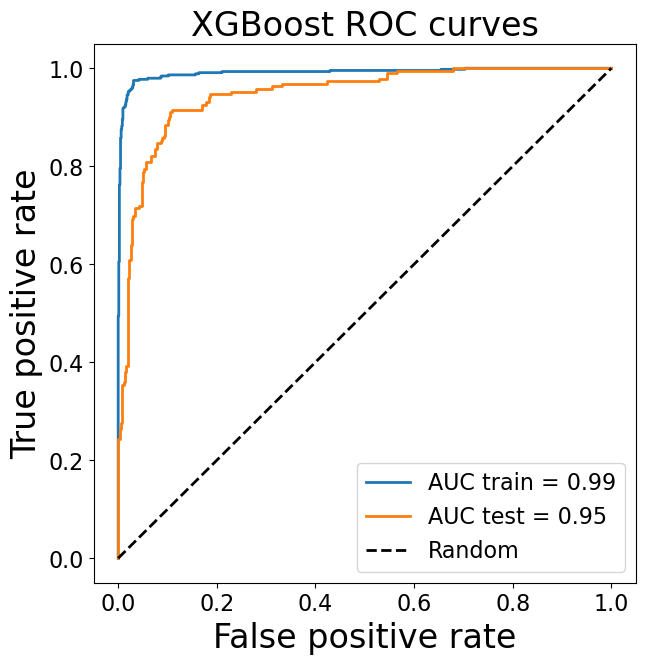

In [48]:
# Probabilidad de las predicciones
pred_prob_train = xgbc_model.predict_proba(X_train)[:, 1]
pred_prob_test = xgbc_model.predict_proba(X_test)[:, 1]

# tasas de falsos positivos / tasas de verdaderos positivos - entrenamiento
fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
# tasas de falsos positivos / tasas de verdaderos positivos - prueba
fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7, 7))
plt.plot(fpr_train, tpr_train, label=f'AUC train = {roc_auc_train:.2f}', lw=2)
plt.plot(fpr_test, tpr_test, label=f'AUC test = {roc_auc_test:.2f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Curva aleatoria

plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title('XGBoost ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

# Actividad Práctica

Teniendo en cuenta lo revisado, realice un código en python con el cual:

Descarge 10 compuestos aleatorios de la base de datos de ChEMBL con un peso molecular entre 500 y 600 g/mol y prediga si esos compuestos son activos o inactivos frente a la proteína *Glycogen synthase kinase-3 beta* utilizando el modelo de machine learning XGBoost empleado en esta práctica.


Al finalizar deberá preparar un documento en formato PDF en el cual muestre el input y como resultado de ejecución:
1. Una tabla con:
    * ChEMBL ID.
    * La estructura de los 10 compuestos.
    * pchembL_value.
    * Las reglas de Lipinski (peso molecular, aceptores y donores de enlaces de hidrogéno y logP).
    * Si cumplen o no con las reglas de Lipinski.
    * Valor de la probablidad de ser o no activo.  

# Conclusiones
A lo largo de esta práctica, trabajamos con dos algoritmos de clasificación ampliamente utilizados: Random Forest y XGBoost. Cada uno de estos algoritmos tiene sus propias ventajas y limitaciones, y su desempeño puede variar enormemente dependiendo del tipo de datos y la configuración de los parámetros.

Nuestro primer enfoque fue emplear el algoritmo de Random Forest utilizando los parámetros predeterminados. Aunque Random Forest es conocido por su capacidad para manejar una amplia gama de problemas de clasificación, observamos que, en nuestro caso, el modelo resultante sufría de sobreajuste. El sobreajuste es un fenómeno común en el aprendizaje automático, donde un modelo memoriza las características del conjunto de entrenamiento en lugar de aprender a generalizar a partir de las características subyacentes. Esto limita la capacidad del modelo para realizar predicciones precisas en datos no vistos.

Para abordar este problema, experimentamos con un segundo algoritmo: XGBoost. XGBoost es un algoritmo potente y flexible que puede ser especialmente efectivo para abordar problemas de sobreajuste si se configura correctamente. Para nuestro modelo XGBoost, definimos un conjunto inicial de parámetros y observamos que, después de entrenar y validar el modelo, el sobreajuste había disminuido.

Es crucial recordar que no existe un algoritmo de clasificación "mejor" o "peor" en general. La eficacia de un algoritmo depende en gran medida de los datos con los que se trabaje y de cómo se configuren sus parámetros. Por tanto, el proceso de buscar el algoritmo de clasificación más adecuado para un problema dado suele implicar la experimentación con diferentes modelos y la ajuste de sus parámetros. En última instancia, la elección del algoritmo y su configuración es un equilibrio entre el rendimiento del modelo, la interpretabilidad y la eficiencia computacional.

Como continuación a esta práctica, sería interesante explorar otros modelos de clasificación, así como experimentar con diferentes técnicas de ajuste de parámetros, como la búsqueda de cuadrícula o la optimización bayesiana, para seguir mejorando el desempeño de nuestro modelo de clasificación.

# Referencias
1. Sarica, A., Cerasa, A., & Quattrone, A. (2017). Random forest algorithm for the classification of neuroimaging data in alzheimer’s disease: A systematic review. Frontiers in Aging Neuroscience, 9. https://www.frontiersin.org/articles/10.3389/fnagi.2017.00329
2. Refaeilzadeh, P., Tang, L., & Liu, H. (2009). Cross-validation. En L. LIU & M. T. ÖZSU (Eds.), Encyclopedia of Database Systems (pp. 532-538). Springer US. https://doi.org/10.1007/978-0-387-39940-9_565
3. Larrañaga, P., Calvo, B., Santana, R., Bielza, C., Galdiano, J., Inza, I., Lozano, J. A., Armañanzas, R., Santafé, G., Pérez, A., & Robles, V. (2006). Machine learning in bioinformatics. Briefings in Bioinformatics, 7(1), 86-112. https://doi.org/10.1093/bib/bbk007
4. Extended connectivity fingerprint ecfp | chemaxon docs. (s. f.). https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md
5. Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). New York, NY, USA: ACM. https://doi.org/10.1145/2939672.2939785